# Super Resolution
&emsp;&emsp;Image super-resolution (SR) problem, particularly single image super-resolution (SISR), has gained increasing
research attention for decades. SISR aims to reconstruct
a high-resolution image $I^{SR}$ from a single low-resolution
image ILR. Generally, the relationship between $I^{LR}$ and
the original high-resolution image $I^{HR}$ can vary depending
on the situation. Many studies assume that $I^{LR}$ is a bicubic
downsampled version of $I^{HR, but other degrading factors
such as blur, decimation, or noise can also be considered for
practical applications.<br/>

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os 
import cv2
import glob
import matplotlib.pyplot as plt
import copy
import random
from skimage.metrics import structural_similarity as SSIM
from tqdm import tqdm
import time
%matplotlib inline
dev='cuda' if torch.cuda.is_available() else 'cpu'
dev

'cuda'

# Load Data
&emsp;&emsp;Dataset is [BSDS500](https://pan.baidu.com/s/1-d2rIC3JP0Hdiekicvo8Tw?pwd=giuc), containing 300 training images and 200 test images of size 481×321.<br/><br/>
&emsp;&emsp;Image patches are cropped from each image in the size of 20×20.

In [2]:
def crop_patch(img,h,w,img_list):
    c,height,width=img.shape
    nh=height//h
    nw=width//w
    for i in range(nh):
        for j in range(nw):
            x=img[:,i*h:i*h+h,j*h:j*h+h]
            img_list.append(x)

In [41]:
root_path='.\\bsds500'

train_files= glob.glob1(os.path.join(root_path,'trainval'),'*.jpg')
train_hrs_patch=[]
train_hrs=[]
for file in train_files:
    img = cv2.imread(os.path.join(root_path,'trainval',file))[:-1,:-1,:]
    img=img[:,:,[2,1,0]].transpose(2,0,1)
    if img.shape[1]==480:
        img=img.transpose(0,2,1)
    crop_patch(img,20,20,train_hrs_patch)
    train_hrs.append(img)
    
train_hrs=np.array(train_hrs)
train_hrs=torch.from_numpy(train_hrs).to(torch.float32)/255

train_hrs_patch=np.array(train_hrs_patch)
train_hrs_patch=torch.from_numpy(train_hrs_patch).to(torch.float32)/255

test_files= glob.glob1(os.path.join(root_path,'test'),'*.jpg')
test_hrs=[]
test_hrs_patch=[]
for file in test_files:
    img = cv2.imread(os.path.join(root_path,'test',file))[:-1,:-1,:]
    img=img[:,:,[2,1,0]].transpose(2,0,1)
    if img.shape[1]==480:
        img=img.transpose(0,2,1)
    crop_patch(img,20,20,test_hrs_patch)
    test_hrs.append(img)
    
test_hrs=np.array(test_hrs)
test_hrs=torch.from_numpy(test_hrs).to(torch.float32)/255
test_hrs_patch=np.array(test_hrs_patch)
test_hrs_patch=torch.from_numpy(test_hrs_patch).to(torch.float32)/255
# Number_of_Images*Channels*Height*Width
print('Shape:Number×Channel×Height×Width.\nShape of train_hrs:%d×%d×%d×%d;\nShape of test_hrs:%d×%d×%d×%d.'
      %(train_hrs.shape[0],train_hrs.shape[1],train_hrs.shape[2],train_hrs.shape[3],
        test_hrs.shape[0],test_hrs.shape[1],test_hrs.shape[2],test_hrs.shape[3]))
print('Shape of train_hrs_patch:%d×%d×%d×%d;\nShape of test_hrs_patch:%d×%d×%d×%d.'
      %(train_hrs_patch.shape[0],train_hrs_patch.shape[1],train_hrs_patch.shape[2],train_hrs_patch.shape[3],
        test_hrs_patch.shape[0],test_hrs_patch.shape[1],test_hrs_patch.shape[2],test_hrs_patch.shape[3]))

Shape:Number×Channel×Height×Width.
Shape of train_hrs:300×3×320×480;
Shape of test_hrs:200×3×320×480.
Shape of train_hrs_patch:115200×3×20×20;
Shape of test_hrs_patch:76800×3×20×20.


# Generate LR Images from HR Images
&emsp;&emsp;The downsampling and degradation of HR images can be described as<br/>
<center>
    $I^{LR}=I^{HR}*k+n$<br/>
</center>    
where $k$ denotes the downsampling kernel, $n$ denotes noise and $*$ denotes convolution operator.<br/><br/>
&emsp;&emsp;HR images are downsampled through bicubic downsampling and then degraded with Gaussian noise ($\mu=0,\sigma=0.05$) added to generate LR images.

In [4]:
def degrade(img,mean,std):
    noise=torch.randn(img.shape)*std+mean
    return torch.clip(noise+img,min=0,max=1)

def downsample(hrs,scale_factor=.5,mode='bicubic',mean=0,std=.05,align_corners=True):
    lrs=F.interpolate(hrs,scale_factor=scale_factor,mode=mode,align_corners=align_corners)
    lrs=degrade(lrs,mean,std)
    return lrs

In [42]:
train_lrs=downsample(train_hrs)
test_lrs=downsample(test_hrs)
train_lrs_patch=downsample(train_hrs_patch)
test_lrs_patch=downsample(test_hrs_patch)

### Display the LR and HR version of an image from training set.

LR and HR version of the 61th image in training set.


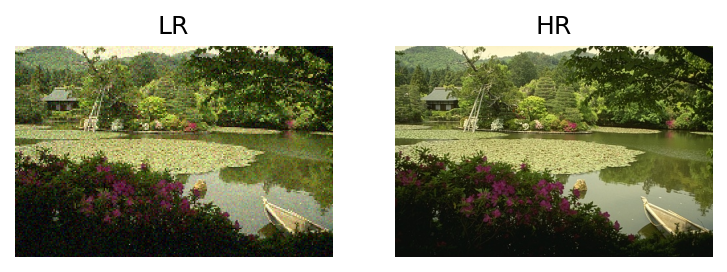

In [40]:
rand_idx=np.random.randint(train_lrs.shape[0])
fig,(ax1,ax2)=plt.subplots(1,2,dpi=150)
ax1.imshow(train_lrs[rand_idx].numpy().transpose(1,2,0))
ax1.set_title('LR')
ax1.axis('off')
ax2.imshow(train_hrs[rand_idx].numpy().transpose(1,2,0))
ax2.set_title('HR')
ax2.axis('off')
print('LR and HR version of the %dth image in training set.'%rand_idx)

### Display the LR and HR version of an image patch from training set.

LR and HR version of the 49027th image patch in training set (patch).


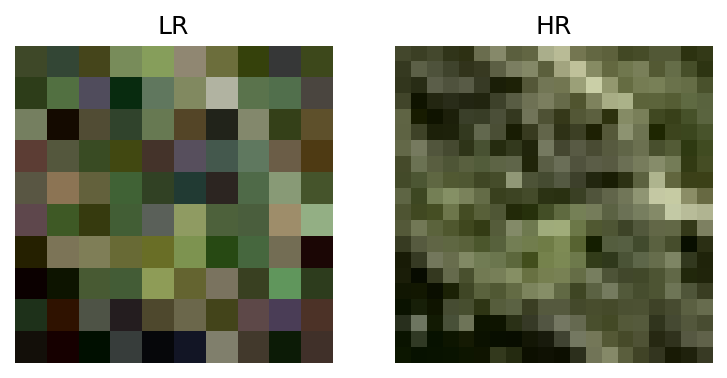

In [7]:
rand_idx=np.random.randint(train_lrs_patch.shape[0])
fig,(ax1,ax2)=plt.subplots(1,2,dpi=150)
ax1.imshow(train_lrs_patch[rand_idx].numpy().transpose(1,2,0))
ax1.set_title('LR')
ax1.axis('off')
ax2.imshow(train_hrs_patch[rand_idx].numpy().transpose(1,2,0))
ax2.set_title('HR')
ax2.axis('off')
print('LR and HR version of the %dth image patch in training set (patch).'%rand_idx)

### Make data loader.

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,lrs,hrs):
        self.lrs=lrs
        self.hrs=hrs

    def __getitem__(self,index):
        lr,hr=self.lrs[index],self.hrs[index]
        return lr, hr

    def __len__(self):
        return len(self.lrs)

In [9]:
batch_size=16
trainset=Dataset(train_lrs_patch,train_hrs_patch)
testset=Dataset(test_lrs_patch,test_hrs_patch)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True)

# Model

## EDSR 

&emsp;&emsp;**EDSR**, short for Enhanced Deep Residual Networks, is proposed by B. Lim, S. Son, H. Kim, S. Nah and K. M. Lee in [*Enhanced Deep Residual Networks for Single Image Super-Resolution*](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8014885), 2017 IEEE CVPRW.<br/>
&emsp;&emsp;Its structure is shown in Fig.1. Note that there is no ReLU layer outside the residual blocks. The whole network consists of two models: **the single-scale model** and **the multi-scale model**. The **single-scale model** consists of an input convolutional layer, $B$ residual blocks, and an output convolution layer, with $F$ feature maps in each layer. The residual scaling factor is set to $\gamma$ to from residual connection, which is the same for residual blocks. Each feature map shares the same size of $H×W$ with the original input image. Besides, the **multi-scale model** consists of an upsampling layer and pixel shuffle layer. The upsampling layer maps the $F$ input feature maps with the size of $H×W$ to $s^2F$ feature maps of the same size, and then shuffled to $F$ feature maps with the size of $sH×sW$ via pixel shuffle layers. The following convolutional layer maps the $F$ $sH×sW$ feature maps to the $sH×sW$ SR image with 3 RGB channels.
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="notebook_resources/edsr_struct.png" width = "60%" alt=""/>
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">
      Fig.1: Network Structure of EDSR
  	</div>
</center>
&emsp;&emsp;Modified structure of residual block is shown in Fig.2. Unlike residual blocks in SRCNN, residual blocks in EDSR are improved, with batch normalization layers removed, since they normalize the features thus getting rid of range flexibility from networks. The number of feature maps in each layer is also $F$. The authors experimentally demonstrate that this simple modification increases the performance substantially in the paper. Saved resources can be used to deepen the network with more residual blocks added. 

<br/>
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="notebook_resources/res_comp.png" width = "60%" alt=""/>
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">
      Fig.2: Comparison of Residual Blocks
  	</div>
</center>
<br/>
&emsp;&emsp;In this experiment, the inputs are batches of image patches cropped from the original image with the size of $H×W$ and batch size of $N$, and parameters are set as follows:
<br/>
<center>
    $B=32,F=256,\gamma=0.1,H=W=20,N=16$
    <br/>
</center>

In [10]:
class ResBlock(nn.Module):
    def __init__(self,in_ch):
        super().__init__()
        self.Convs=nn.Sequential(nn.Conv2d(in_ch,in_ch,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_ch,in_ch,kernel_size=3,stride=1,padding=1))
        
    def forward(self,x):
        out=self.Convs(x)
        out*=.1
        out+=x
        return out
    
class EDSR(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,feat=256,num_block=32):
        super().__init__()
        self.feat=feat
        self.conv1=nn.Conv2d(in_ch,feat,kernel_size=3,stride=1,padding=1)
        self.body=self.make_layer(num_block)
        self.conv2=nn.Conv2d(feat,feat,kernel_size=3,stride=1,padding=1)
        self.up=nn.Conv2d(feat,feat*4,kernel_size=3,stride=1,padding=1)
        self.upsample=nn.Sequential(self.up,nn.PixelShuffle(2))
        self.conv3=nn.Conv2d(feat,out_ch,kernel_size=3,stride=1,padding=1)
        
    def make_layer(self,layers):
        res_block=[]
        for _ in range(layers):
            res_block.append(ResBlock(self.feat))
        return nn.Sequential(*res_block)
    
    def forward(self,x):
        out1=self.conv1(x)
        out2=self.conv2(self.body(out1))
        out2+=out1
        out2=self.upsample(out2)
        out2=self.conv3(out2)
        return out2

# Evaluation
&emsp;&emsp;PSNR (Peak Signal to Noise Ratio) and SSIM (Structural Similarity) are chosen as evaluation measurements of the reconstruction quality.
<br/><br/>
<center>
    <font size=5>
    $PSNR=10lg\frac{255}{MSE}$<br/><br/>
    $SSIM(x,y)=\frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1))(\sigma_x^2+\sigma_y^2+c_2)}$</center>
     <font face='Times New Roman' size=3>
         <br\><br\>
         Where $MSE$ denotes mean squre error, $c_1=(k_1L)^2,c_2=(k_2L)^2,k_1=0.01,k_2=0.03,L=255$.


    


In [67]:
def psnr(x,y):
   # x,y:n*c*h*w
    with torch.no_grad(): 
        x_=(255*x).to(torch.uint8).to(torch.float32)
        y_=(255*y).to(torch.uint8).to(torch.float32)
        #print(x_)
        mse=torch.mean((x_-y_)**2,dim=[1,2,3])
        #mse=torch.mean(mse)
        #print(mse)
        
        #print(mse)
        return torch.mean(10*torch.log10(255*255/(mse+1e-7))).item()

def ssim(x,y):
    x_,y_=x.cpu(),y.cpu()
    s=0
    if len(x.shape)==3:
        x_=x_.unsqueeze(0)
    if len(y.shape)==3:
        y_=y_.unsqueeze(0)
    n,c,h,w=x_.shape
    x_=(255*x_).to(torch.uint8).numpy()#.transpose(0,2,3,1)
    y_=(255*y_).to(torch.uint8).numpy()#.transpose(0,2,3,1)
    #print(x_.shape)
    for i in range(n):
        for j in range(c):
            s+=SSIM(x_[i,j],y_[i,j])
    return s/(n*c)
#SSIM(np.random.randn(8,8),np.random.randn(8,8))
#ssim(torch.rand((4,3,50,50)),torch.rand(4,3,50,50))#(torch.rand)

# Training
&emsp;&emsp;$l_1 norm$ of SR image $I^{SR}$ and HR image $I^{HR}$ is chosen as the loss function for training.<br/>
<center>
    $Loss=||I^{SR}-I^{HR}||_1$<br/><br/>
</center>
&emsp;&emsp;The model is trained by Adam optimizer for 5 epochs.<br/><br/>
&emsp;&emsp;Learning rate is set to 0.0001, and halved at every 2 epochs.

In [12]:
epochs=5
lr=1e-4
edsr=EDSR().to(dev)
lr_list=[]
loss_fn=nn.L1Loss()
optimizer=torch.optim.Adam(edsr.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5, last_epoch=-1)
min_loss=100
print('===============Training Starts===============')
print('total epochs:%d, initial learning rate:%f'%(epochs,lr))
for epoch in range(epochs):    
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
    meanloss=0
    meanpsnr=0
    meanssim=0
    with tqdm(range(train_hrs_patch.shape[0]//batch_size),ncols=100) as pbar:
        pbar.set_description('Epoch %d'%(epoch+1))
        for i,(x,y) in enumerate(trainloader):
            time.sleep(0.01)
            x=x.to(dev)
            x.requires_grad=True
            y=y.to(dev)
            y.requires_grad=True
            y_pred=edsr(x)
            loss=loss_fn(255*y_pred,255*y) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            meanloss+=loss*x.shape[0]
            psnr_=psnr(y_pred,y)
            ssim_=ssim(y_pred,y)
            meanpsnr+=psnr_*x.shape[0]
            meanssim+=ssim_*x.shape[0]
            if loss.item()<min_loss:
                optimal_state_dict=copy.deepcopy(edsr.state_dict())
                min_loss=loss.item()
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            pbar.set_postfix(loss=loss.item(),psnr='%.3fdB'%psnr_,ssim=ssim_)
            pbar.update(1)
    meanloss/=train_lrs_patch.shape[0]
    meanpsnr/=train_lrs_patch.shape[0]
    meanssim/=train_lrs_patch.shape[0]
    tqdm.write('lr=%f,mean loss=%f,mean psnr=%fdB,mean ssim=%f,minimum loss=%f'%(lr_list[-1],meanloss,meanpsnr,meanssim,min_loss))
    scheduler.step()
print('===============Training Ends===============')

===============Training Starts===============
total epochs:5, initial learning rate:0.000100


Epoch 1: 100%|████████████| 7200/7200 [24:50<00:00,  4.83it/s, loss=8.54, psnr=26.447dB, ssim=0.722]


lr=0.000100,mean loss=8.270473,mean psnr=26.923277dB,mean ssim=0.748190,minimum loss=4.529124


Epoch 2: 100%|████████████| 7200/7200 [24:35<00:00,  4.88it/s, loss=7.23, psnr=27.505dB, ssim=0.785]


lr=0.000100,mean loss=7.627843,mean psnr=27.739538dB,mean ssim=0.772305,minimum loss=4.106999


Epoch 3: 100%|█████████████| 7200/7200 [24:35<00:00,  4.88it/s, loss=6.2, psnr=30.739dB, ssim=0.813]


lr=0.000050,mean loss=7.332323,mean psnr=28.214526dB,mean ssim=0.783302,minimum loss=3.825724


Epoch 4: 100%|████████████| 7200/7200 [24:36<00:00,  4.87it/s, loss=5.91, psnr=28.486dB, ssim=0.814]


lr=0.000050,mean loss=7.264112,mean psnr=28.293297dB,mean ssim=0.785930,minimum loss=3.741312


Epoch 5: 100%|████████████| 7200/7200 [24:36<00:00,  4.88it/s, loss=6.52, psnr=30.330dB, ssim=0.825]

lr=0.000025,mean loss=7.129648,mean psnr=28.526606dB,mean ssim=0.791043,minimum loss=3.497120
===============Training Ends===============


### Save the state dictionary of trained model

In [35]:
torch.save(edsr.state_dict(),'edsr.pkl')
#torch.save(optimal_state_dict,'edsr.pkl')

### Load state dictionary.

In [14]:
optimal_edsr=EDSR().to(dev)
optimal_edsr.load_state_dict(torch.load('edsr.pkl'))

<All keys matched successfully>

# Evaluate the model

### Visualize EDSR model on random test image.


Bicubic:PSNR=18.157738dB,SSIM=0.595036

EDSR:PSNR=22.202183dB,SSIM=0.739841


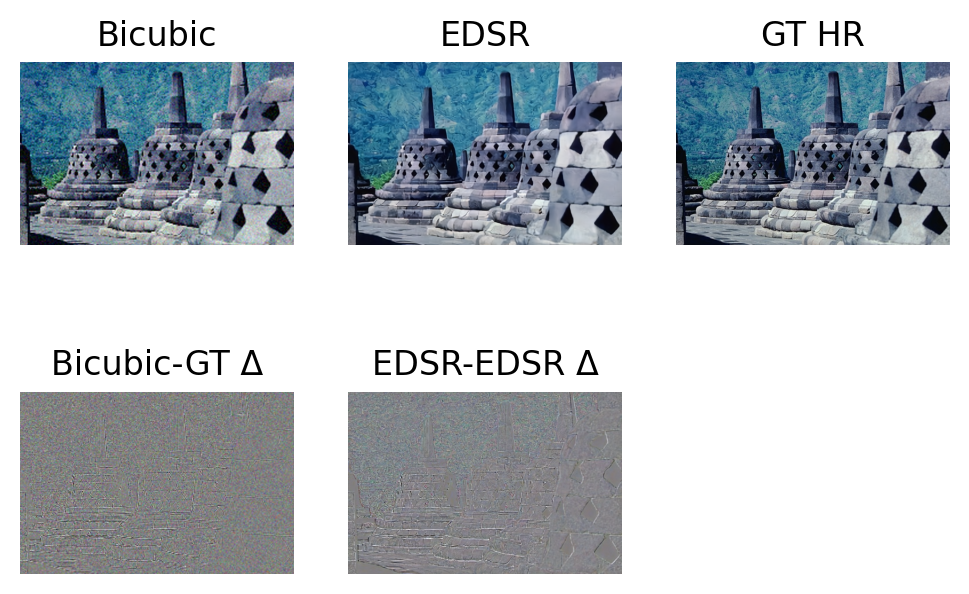

In [75]:
choice='test'
rand_idx=np.random.randint(len(train_lrs)) if choice=='train' else np.random.randint(len(test_lrs))
def visualize(idx,model,dataset='train'):
    torch.cuda.empty_cache()
    if dataset not in ('train','test'):
        raise ValueError('Dataset must be either \'train\' or \'test\'!')
    fig,ax=plt.subplots(2,3,dpi=200)
    plt.delaxes(ax[1,2])
    ax1,ax2,ax3,ax4,ax5=ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1]
    lrs=train_lrs if dataset=='train' else test_lrs
    hrs=train_hrs if dataset=='train' else test_hrs
    with torch.no_grad():
        x=model.cuda()(lrs[idx].cuda().unsqueeze(0))
    psnr_sr=psnr(x,hrs[idx].unsqueeze(0).cuda())
    ssim_sr=ssim(x,hrs[idx].unsqueeze(0).cuda())
    x=torch.clip(x,min=0,max=1).squeeze(0).cpu().detach().numpy().transpose(1,2,0)
    ax2.imshow(x)
    ax2.set_title('EDSR')
    ax2.axis('off')
    y=F.interpolate(lrs[idx].unsqueeze(0),scale_factor=2,
                               mode='bicubic',align_corners=True)
                 
    psnr_bi=psnr(y,hrs[idx])
    ssim_bi=ssim(y,hrs[idx])
    y=torch.clip(y,min=0,max=1).squeeze(0).numpy().transpose(1,2,0)
    ax1.set_title('Bicubic')
    ax1.imshow(y) 
    ax1.axis('off')
    z=hrs[idx].numpy().transpose(1,2,0)
    ax3.imshow(z)
    ax3.set_title('GT HR')
    ax3.axis('off')
    ax4.imshow(np.clip(y-z+.5,a_min=0,a_max=1))
    ax4.set_title('Bicubic-GT Δ')
    ax4.axis('off')
    ax5.imshow(np.clip(x-z+.5,a_min=0,a_max=1))
    ax5.set_title('EDSR-EDSR Δ')
    ax5.axis('off')
    print('\nBicubic:PSNR=%fdB,SSIM=%f'%(psnr_bi,ssim_bi))
    print('\nEDSR:PSNR=%fdB,SSIM=%f'%(psnr_sr,ssim_sr))
    torch.cuda.empty_cache()
visualize(rand_idx,optimal_edsr,choice)    

### Calculate average PSNR and SSIM on test dataset.

In [36]:
test_psnr=[]
test_ssim=[]
with torch.no_grad():
    for idx,x in enumerate(tqdm(test_lrs,ncols=80)):
        x=optimal_edsr.cuda()(x.cuda().unsqueeze(0))
        psnr_sr=psnr(x,test_hrs[idx].unsqueeze(0).cuda())
        ssim_sr=ssim(x,test_hrs[idx].unsqueeze(0).cuda())
        test_psnr.append(psnr_sr)
        test_ssim.append(ssim_sr)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
print('Average PSNR on test dataset is %fdB,\nAverage SSIM on test dataset is %f.'%(np.mean(test_psnr),np.mean(test_ssim)))

100%|█████████████████████████████████████████| 200/200 [04:02<00:00,  1.21s/it]

Average PSNR on test dataset is 19.004758dB,
Average SSIM on test dataset is 0.759354.


# Conclusion
&emsp;&emsp;EDSR is a very powerful super resolution model. It does particularly well in removing additive noises, like Gaussian noise demonstrated above. Its advantage in improving PSNR and SSIM is limited in this experiment since the total epoch is only set to 5 due to the limitation of my GPU GTX1650. Further improvement in reconstruction quality can be achieved by increasing the total epoch.
### Citation
B. Lim, S. Son, H. Kim, S. Nah and K. M. Lee, "Enhanced Deep Residual Networks for Single Image Super-Resolution," 2017 IEEE Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 2017, pp. 1132-1140, doi: 10.1109/CVPRW.2017.151.